In [52]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from TwoBox_calc_FORCINGS import TwoBox_calc_FORCINGS
from TwoBox_Plot_TimeSeries import TwoBox_Plot_TimeSeries

In [53]:
# TwoBox is a very simple box model calculating the changes in
# global SST temperature with time based on prescribed feedback factors
# and heat capacity with interactions to the deep ocean.
#
# Author: Asgeir Sorteberg,
#         Geophysical Institute, University of Bergen.
#         email: asgeir.sorteberg@gfi.uib.no
#
#         Feb. 2011
############################################################################

In [54]:
# --------------
# read parameters and model settings
# --------------
exec(compile(open('TwoBox_PARAM.py').read(), 'TwoBox_PARAM.py', 'exec'))

In [56]:
print('TwoBox: Model experiment: ' + sim_name)

TwoBox: Model experiment: TwoBox_simulation


In [57]:
# --------------
# sum of feedback parameters [Wm-2K-1]
# --------------
lamda_sum=sum([lambda_planck,
    lambda_lapse,
    lambda_water,
    lambda_cloud,
    lambda_albedo,
    lambda_other])

#print('TwoBox: sum of feedback parameters: ' + str(lamda_sum) + ' Wm-2/K')


In [58]:
# --------------
# Some derived constants
# -------------

# effective heat capacity of the atmosphere-ocean system [J m-2 K-1]
CEFF_M=f_o*H_MIX*CPO*RHO
CEFF_D=f_o*H_DEEP*CPO*RHO

In [59]:
# --------------
# Radiative forcings [W/m2]
# --------------
# calculate forcings relative to base period
base_syr=1750
base_eyr=1750

#print('TwoBox: Forcing calculated relative to ' + str(base_syr) + '-' + str(base_eyr) + ' period')


In [60]:
total_year,total_forcing,wmghg_year,wmghg_data,solar_year,solar_data,volc_year,volc_data,landuse_year,landuse_data,manaero_year,manaero_data=TwoBox_calc_FORCINGS(forcing_dataset,forcing_dir,base_syr,base_eyr)


TwoBox_read_IPCC_AR5_historical_forcing: reading IPCC AR5 forcing data 1750-2011
TwoBox_read_IPCC_AR5_historical_forcing: Finished
TwoBox_read_IPCC_AR5_future_forcing: reading IPCC AR5 forcing data 2010-2090
TwoBox_read_IPCC_AR5_future_forcing: Finished
TwoBox_calc_FORCINGS:Finished


In [61]:
if forcing_dataset.upper().strip() in ['IPCC_AR5_HISTORICAL', 'PMIP3']:
    radiative_forcing=np.zeros(len(total_year))
    forcings_dict={} # store information on which forcings should be plotted later
    # sum up the forcings active
    # Greenhouse gas forcing on=1 off=0
    
    if switch_ghg==1:
        radiative_forcing=radiative_forcing+wmghg_data
        forcings_dict['GREENHOUSE GASES']=wmghg_data
        print('TwoBox: Greenhouse gas forcing: ON')
    else:
        wmghg_data=wmghg_data*0
        print('TwoBox: Greenhouse gas forcing: OFF')
        
    # solar forcing on=1 off=0
    if switch_solar==1:
        radiative_forcing=radiative_forcing+solar_data
        forcings_dict['SOLAR']=solar_data
        print('TwoBox: Solar forcing: ON')
    else:
        solar_data=solar_data*0
        print('TwoBox: Solar forcing: OFF')
    
    # Volcanic forcing on=1 off=0    
    if switch_volc==1:
        radiative_forcing=radiative_forcing+volc_data
        forcings_dict['VOLCANIC']=volc_data
        print('TwoBox: Volcanic forcing: ON')
    else:
        volc_data=volc_data*0
        print('TwoBox: Volcanic forcing: OFF')
    
    # Landuse forcing on=1 off=0
    if switch_land==1:
        radiative_forcing=radiative_forcing+landuse_data
        forcings_dict['LANDUSE']=landuse_data
        print('TwoBox: Landuse forcing: ON')
    else:
        landuse_data=landuse_data*0
        print('TwoBox: Landuse forcing: OFF')
        
    # Pollution particle forcing on=1 off=0
    if switch_aero==1:
        radiative_forcing=radiative_forcing+manaero_data
        forcings_dict['MAN MADE AEROSOLS']=manaero_data
        print('TwoBox: Aerosol forcing: ON')
    else:
        manaero_Data=manaero_data*0
        print('TwoBox: Aerosol forcing: OFF')
        
    
else:
    radiative_forcing=total_forcing

In [62]:
if switch_ocnheat==1:
    print('TwoBox: Deep Ocean heat uptake: ON')
else:
    print('TwoBox: Deep Ocean heat uptake: OFF')
print('TwoBox: Deep Ocean heat uptake: ' + str(gamma) + 'Wm-2/k')

TwoBox: Deep Ocean heat uptake: ON
TwoBox: Deep Ocean heat uptake: -0.6Wm-2/k


In [63]:
if switch_ocnheat==1 and switch_stocastic==1:
    print('TwoBox: Stocastic deep Ocean heat uptake: ON')
    print('TwoBox:  Standard deviation of ocean heat uptake: '+ str(gamma_std)+ 'Wm-2/K')
else:
    print('TwoBox: Stocastic deep Ocean heat uptake: OFF')
    

TwoBox: Stocastic deep Ocean heat uptake: OFF


In [64]:
model_year=total_year

# -------------
# Timestep etc.
# --------------

# timestep in days
Dt_day=365
# timestep in seconds
Dt=Dt_day*24*60*60

In [65]:
# interpolate forcing to chosen timestep
model_year_interp=np.arange(model_year[0], model_year[-1]+1, Dt_day/365)
radiative_forcing_interp_fun=interpolate.interp1d(model_year, radiative_forcing, 'linear')
radiative_forcing_interp=radiative_forcing_interp_fun(model_year_interp)

# Number of timesteps to run model for
Nt=len(model_year_interp)

# Number of times to run model for
if switch_ocnheat==1 and switch_stocastic==1:
    No_sim=10
else:
    No_sim=1

In [66]:
# Deep Ocean heat uptake efficiency
gam=np.ones((No_sim, Nt))*gamma
if switch_ocnheat==1 and switch_stocastic==1:
    for i in range(len(gam)):
        gam[i]=np.random.normal(gamma, gamma_std, Nt)
        # make sure mean is gamma
        gam[i]=gam[i]-np.mean(gam[i]+gamma)

In [67]:
# -------------
# loop over all simulations
# -------------
Ts_all=np.zeros((No_sim, Nt))  #initialize arrays where all data will be stored
To_all=np.zeros((No_sim, Nt))
for i in range(No_sim):
    
    # -------------
    #  Initial condition
    # --------------
    Ts_init=0
    To_init=0
    
    Ts=np.array(()) # initialize arrays where individual time series will be stored
    To=np.array(())
    # -------------
    # Start Time integration
    # -------------
    for t in range(Nt):
        # --------------
        # Temperature tendencies [Ks-1]
        #     dTs/dt, dTs_dt
        # --------------
        
        if t==0:
            dTs_dt=(radiative_forcing_interp[t]+(lamda_sum*Ts_init)+(gam[i,t]*(Ts_init-To_init)))/CEFF_M
            dTo_dt=-gam[i,t]*(Ts_init-To_init)/CEFF_D
        else:
            dTs_dt=(radiative_forcing_interp[t]+(lamda_sum*Ts[t-1])+(gam[i,t]*(Ts[t-1]-To[t-1])))/CEFF_M
            dTo_dt=-gam[i,t]*(Ts[t-1]-To[t-1])/CEFF_D
        
        # ----------------------------------------------------------------------
        # Step temperature forward in time (by "Euler forward"
        # or "forward-in-time" method)
        #----------------------------------------------------------------------
        if t==0:
            Ts=np.append(Ts, Ts_init+dTs_dt*Dt)
            To=np.append(To, To_init+dTo_dt*Dt)
        else:
            Ts=np.append(Ts, Ts[t-1]+dTs_dt*Dt)
            To=np.append(To, To[t-1]+dTo_dt*Dt)
    
    # save data
    Ts_all[i]=Ts
    To_all[i]=To
    #Ts_all=np.append(Ts_all, Ts)
    #To_all=np.append(To_all, To)

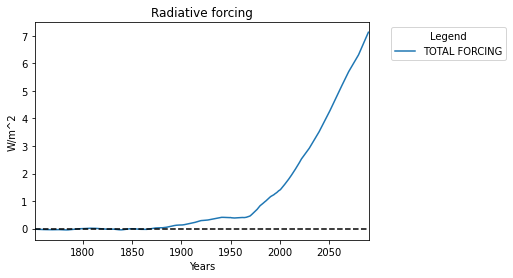

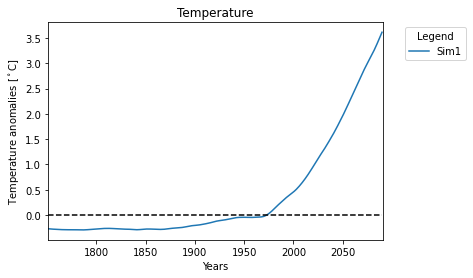

In [68]:
#----------------------------------------------------------------------
# Plot data
#---------------------------------------------------------------------

# ----------------
# Select reference period
# Temp anomalies are in mean 0 over the reference period
# ------------------

# reference period for making anomalies
base_syr=1901
base_eyr=2000

# make model  anomalies  realtive to base period
indx=np.logical_and(model_year>base_syr, model_year<=base_eyr)
Ts_anom=np.zeros((No_sim, Nt))
To_anom=np.zeros((No_sim, Nt))
for i in range(No_sim):
    Ts_anom[i]=Ts_all[i]-np.mean(Ts_all[i, indx])
    To_anom[i]=To_all[i]-np.mean(To_all[i, indx])

    
# figure format
prnt='pdf'
# name of figures
output_name1='TwoBox_Radiative_forcing'
output_name2='TwoBox_Temperature_anomalies'

# -------------
# plot timeseries of forcings
# -------------------

# yeasr to plot
plot_syr=total_year[0]
plot_eyr=total_year[-1]

# Data to plot        
plot_x=np.arange(plot_syr, plot_eyr+1)
plot_data=np.nan*np.ones((int(plot_eyr+1-plot_syr)))

# select times to plot
all_forcings=radiative_forcing
plot_data[np.isin(plot_x, model_year)]=all_forcings[np.isin(model_year, plot_x)]

# x-axis
xaxes_limits=((plot_syr, plot_eyr+1))
#y-axis
#yaxes_limits=((np.min(plot_data)-.1, np.max(plot_data)+.1))

# legend
legend_text='TOTAL FORCING'
legend_labels=[]

y_label='W/m^2'
x_label='Years'
figure_text='Radiative forcing'

ps=[]
Figure1=plt.figure(1)
ps.append(TwoBox_Plot_TimeSeries(plot_x,plot_data,xaxes_limits,x_label,[],y_label,figure_text,legend_text))

if forcing_dataset.upper().strip() in ['IPCC_AR5_HISTORICAL', 'PMIP3']:
    for forcing in forcings_dict.keys():
        #plot_data=np.array(list(forcings_dict.values()))
        plot_data=forcings_dict[forcing]
        legend_text=forcing
        ps.append(TwoBox_Plot_TimeSeries(plot_x, plot_data, xaxes_limits, x_label, [], y_label, figure_text, legend_text))
plt.legend(handles=ps, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')


ps=[]
Figure2=plt.figure(2)
# Data to plot        
plot_x=np.arange(plot_syr, plot_eyr+1)
plot_data=Ts_anom

# select times to plot
plot_data[:,np.isin(plot_x, model_year)]=Ts_anom[:,np.isin(model_year, plot_x)]
        
yaxes_limits=((np.min(plot_data)-.1, np.max(plot_data)+.1))
y_label='Temperature anomalies [$^\circ$C]'
figure_text='Temperature'
for i, data in enumerate(plot_data):
    legend_text='Sim{}'.format(i+1)
    ps.append(TwoBox_Plot_TimeSeries(plot_x,data,xaxes_limits,x_label,[],y_label,figure_text,legend_text))
plt.legend(handles=ps, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
